In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install optuna > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
import tensorflow as tf

In [ ]:
tf.random.set_seed(47)
np.random.seed(47)

In [ ]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

In [ ]:
plt.rcParams['figure.figsize'] = (16,6)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving vnet_feb20.csv to vnet_feb20.csv


In [ ]:
df = pd.read_csv('vnet_feb20.csv')
df['Date'] = pd.to_datetime(df.Date)

In [ ]:
# Include only the desired columns (Open, Close, Low, High, Adj Close) and drop 'Volume'
df = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']]

# Optionally, you can rename the columns for consistency
df.columns = ['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close']

# Display the first few rows of the updated DataFrame
print(df.head())

        Date       Open      Close    Low       High  Adj Close
0 2011-04-25  19.400000  17.750000  17.32  19.500000  17.750000
1 2011-04-26  17.700001  17.559999  17.40  18.709999  17.559999
2 2011-04-27  17.840000  16.250000  15.80  17.840000  16.250000
3 2011-04-28  16.110001  16.030001  15.70  16.780001  16.030001
4 2011-04-29  15.950000  15.510000  15.30  16.420000  15.510000


In [ ]:
df.describe()

,Date,Open,Close,Low,High,Adj Close
count,2226,2226.000000,2226.000000,2226.000000,2226.000000,2226.000000
mean,2015-09-25 01:08:34.285714176,12.731420,12.722057,12.427862,13.024802,12.722057
min,2011-04-25 00:00:00,4.170000,4.180000,4.170000,4.420000,4.180000
25%,2013-07-11 06:00:00,8.180000,8.202500,8.042500,8.360000,8.202500
50%,2015-09-24 12:00:00,10.360000,10.350000,10.060000,10.580000,10.350000
75%,2017-12-07 18:00:00,17.680000,17.655000,17.110001,18.100000,17.655000
max,2020-02-27 00:00:00,31.780001,31.959999,31.049999,32.340000,31.959999
std,NaN,6.103256,6.092258,5.951529,6.242617,6.092258


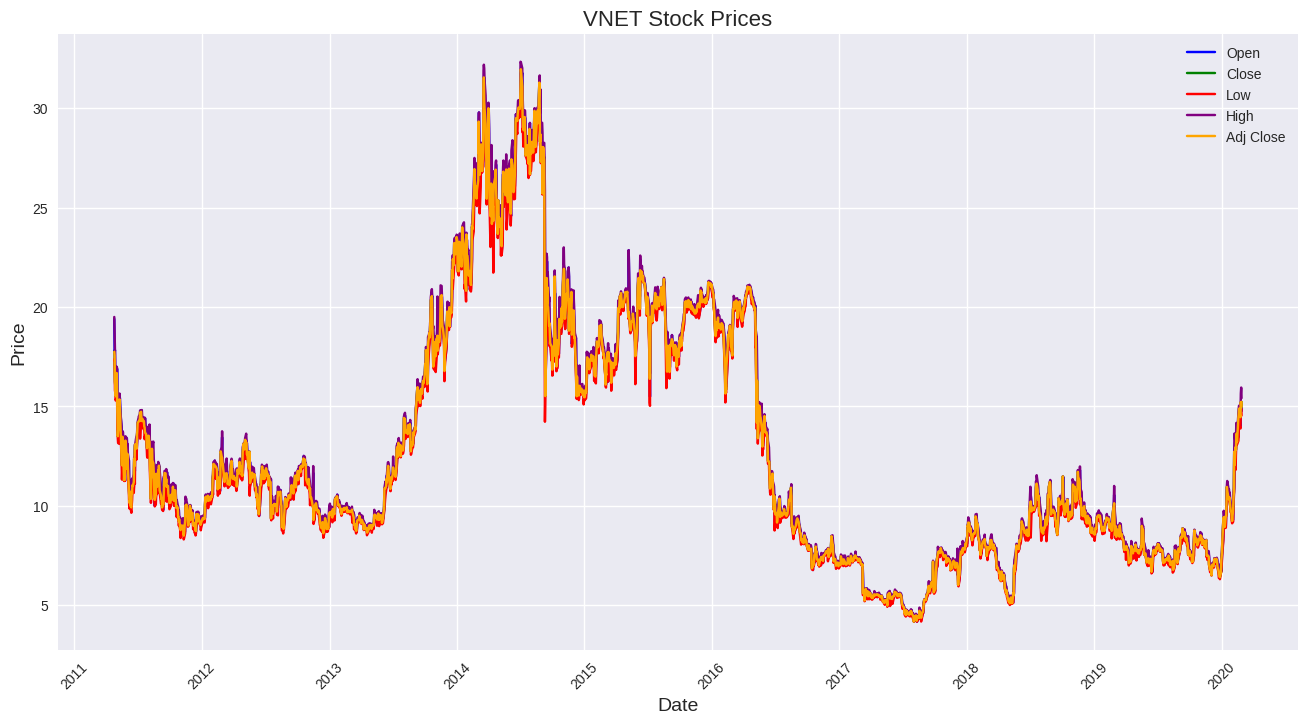

In [ ]:
plt.figure(figsize=(16, 8))  # Set the figure size

plt.title('VNET Stock Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

# Plot all price columns
plt.plot(df['Date'], df['Open'], label='Open', color='blue')
plt.plot(df['Date'], df['Close'], label='Close', color='green')
plt.plot(df['Date'], df['Low'], label='Low', color='red')
plt.plot(df['Date'], df['High'], label='High', color='purple')
plt.plot(df['Date'], df['Adj Close'], label='Adj Close', color='orange')

plt.legend()  # Show legend
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Show grid
plt.show()

In [ ]:
# Calculate the average price for each day
df['avg_price'] = df[['Open', 'Close', 'Low', 'High', 'Adj Close']].mean(axis=1)

# Calculate percentage change based on the average price
df['returns'] = df['avg_price'].pct_change() * 100

# Drop any rows with missing values generated by pct_change()
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the DataFrame to verify the changes
print(df.head())

        Date       Open      Close    Low       High  Adj Close  avg_price  \
0 2011-04-26  17.700001  17.559999  17.40  18.709999  17.559999  17.786000   
1 2011-04-27  17.840000  16.250000  15.80  17.840000  16.250000  16.796000   
2 2011-04-28  16.110001  16.030001  15.70  16.780001  16.030001  16.130001   
3 2011-04-29  15.950000  15.510000  15.30  16.420000  15.510000  15.738000   
4 2011-05-02  15.740000  16.680000  15.54  17.000000  16.680000  16.328000   

    returns  
0 -3.041869  
1 -5.566174  
2 -3.965225  
3 -2.430259  
4  3.748888  


In [ ]:
# Create a new DataFrame 'data' with all price features and returns
data = df[['Date', 'Open', 'Close', 'Low', 'High', 'Adj Close', 'returns']]

# Display the first few rows of the new DataFrame
print(data.head())

        Date       Open      Close    Low       High  Adj Close   returns
0 2011-04-26  17.700001  17.559999  17.40  18.709999  17.559999 -3.041869
1 2011-04-27  17.840000  16.250000  15.80  17.840000  16.250000 -5.566174
2 2011-04-28  16.110001  16.030001  15.70  16.780001  16.030001 -3.965225
3 2011-04-29  15.950000  15.510000  15.30  16.420000  15.510000 -2.430259
4 2011-05-02  15.740000  16.680000  15.54  17.000000  16.680000  3.748888


In [ ]:
# Convert the 'data' DataFrame to a NumPy array
data_array = data.values

# Display the shape of the array
print("Shape of the NumPy array:", data_array.shape)

# Optionally, display the array
print(data_array)

Shape of the NumPy array: (2225, 7)
[[Timestamp('2011-04-26 00:00:00') 17.700001 17.559999 ... 18.709999
  17.559999 -3.041868730920172]
 [Timestamp('2011-04-27 00:00:00') 17.84 16.25 ... 17.84 16.25
  -5.56617351998594]
 [Timestamp('2011-04-28 00:00:00') 16.110001 16.030001 ... 16.780001
  16.030001 -3.965225053584198]
 ...
 [Timestamp('2020-02-25 00:00:00') 14.82 15.22 ... 15.65 15.22
  5.717880609534465]
 [Timestamp('2020-02-26 00:00:00') 15.22 14.95 ... 15.95 14.95
  0.46284051838136886]
 [Timestamp('2020-02-27 00:00:00') 14.77 15.23 ... 15.42 15.23
  -1.0267210741081945]]


In [ ]:
# Drop the 'Date' column from the DataFrame
data = data.drop('Date', axis=1).values

# Display the shape of the array
print("Shape of the NumPy array:", data.shape)

# Optionally, display the array
print(data)

Shape of the NumPy array: (2225, 6)
[[17.700001   17.559999   17.4        18.709999   17.559999   -3.04186873]
 [17.84       16.25       15.8        17.84       16.25       -5.56617352]
 [16.110001   16.030001   15.7        16.780001   16.030001   -3.96522505]
 ...
 [14.82       15.22       14.71       15.65       15.22        5.71788061]
 [15.22       14.95       14.9        15.95       14.95        0.46284052]
 [14.77       15.23       14.54       15.42       15.23       -1.02672107]]


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_data = train_test_split(data, test_size=0.05, shuffle=False)
X_val, X_test = train_test_split(X_data, test_size=0.50, shuffle=False)

print(X_train.shape, X_val.shape, X_test.shape, sep='\n')

(2113, 6)
(56, 6)
(56, 6)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
LAG_DAYS = 1

# Generate Training set
train_gen = TimeseriesGenerator(X_train, X_train[:,0], length=LAG_DAYS, batch_size=1)

print('Train Samples: %d' % len(train_gen))

x_train, y_train = [], []
for i in range(len(train_gen)):
    x, y = train_gen[i]
    x_train.append(x[0])
    y_train.append(y[0])
x_train = np.array(x_train)
y_train = np.array(y_train)

# Generate Validation set
val_gen = TimeseriesGenerator(X_val, X_val[:,0], length=LAG_DAYS, batch_size=1)

print('Validation Samples: %d' % len(val_gen))

x_val, y_val = [], []
for i in range(len(val_gen)):
    x, y = val_gen[i]
    x_val.append(x[0])
    y_val.append(y[0])
x_val = np.array(x_val)
y_val = np.array(y_val)

# Generate Test set
test_gen = TimeseriesGenerator(X_test, X_test[:,0], length=LAG_DAYS, batch_size=1)

print('Test Samples: %d' % len(test_gen))

x_test, y_test = [], []
for i in range(len(test_gen)):
    x, y = test_gen[i]
    x_test.append(x[0])
    y_test.append(y[0])
x_test = np.array(x_test)
y_test = np.array(y_test)

Train Samples: 2112
Validation Samples: 55
Test Samples: 55


In [ ]:
def prep_data_transform(data, length):
    '''Prepare data for inverse transform'''
    a = []
    a.append(data)
    [a.append(np.zeros(data.shape)) for i in range(1,length)]
    return np.c_[a].T

In [ ]:
Y_train = np.round(scaler.inverse_transform(prep_data_transform(y_train, X_train.shape[1])))[:,0]
Y_val = np.round(scaler.inverse_transform(prep_data_transform(y_val, X_val.shape[1])))[:,0]
Y_test = np.round(scaler.inverse_transform(prep_data_transform(y_test, X_test.shape[1])))[:,0]

print(Y_train.shape, Y_val.shape, Y_test.shape)

(2112,) (55,) (55,)


In [ ]:
x_train[1], y_train[0]

(array([[0.49511045, 0.43448526, 0.43266371, 0.48065903, 0.43448526,
         0.36621941]]),
 0.4951104492897338)

In [ ]:
x_val[1], y_val[0]

(array([[0.15320535, 0.15298777, 0.15736608, 0.1515043 , 0.15298777,
         0.50230398]]),
 0.15320535482776695)

In [ ]:
x_test[1], y_test[0]

(array([[0.10068815, 0.100072  , 0.10193453, 0.09455587, 0.100072  ,
         0.4949226 ]]),
 0.10068815281824875)

In [ ]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D

In [ ]:
# Define EarlyStopping callback
early_stopping_rounds = EarlyStopping(monitor='loss', patience=50)

In [ ]:
def run(trial):
    space = {
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'RMSprop']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'epochs': trial.suggest_int('epochs', 50, 200),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64])
    }

    n_timesteps = x_train.shape[1]  # Assuming x_train is your input data
    n_features = x_train.shape[2]


    # Reshape the input data to align with Conv1D layer within TimeDistributed
    x_train_reshaped = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
    x_val_reshaped = x_val.reshape((x_val.shape[0], x_val.shape[1], x_val.shape[2], 1))

    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(x_train.shape[1], x_train.shape[2], 1)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))

    if space['optimizer'] == 'Adam':
        optimizer = optimizers.Adam(learning_rate=space['learning_rate'])
    else:
        optimizer = optimizers.RMSprop(learning_rate=space['learning_rate'])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

    model.fit(x_train_reshaped, y_train, epochs=space['epochs'], validation_data=(x_val_reshaped, y_val),
              batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    yhat_val = model.predict(x_val_reshaped)

    rmse = mean_squared_error(y_val, yhat_val, squared=False) if not np.isnan(yhat_val).any() else 99999
    return rmse

In [ ]:
# Hyperparameter Optimization with Conv LSTM
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=10, n_jobs=-1)
print('Best trial: {}'.format(study.best_trial))

[I 2024-07-06 12:23:56,956] A new study created in memory with name: no-name-8cb82886-412a-4055-a3d2-8134d78a9a86


2/2 [==============================] - 0s 6ms/step


[I 2024-07-06 12:25:24,148] Trial 1 finished with value: 0.004744816030437381 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0011637326952294237, 'epochs': 151, 'batch_size': 64}. Best is trial 1 with value: 0.004744816030437381.
[I 2024-07-06 12:25:24,169] Trial 0 finished with value: 0.005592311603468076 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0005005762459023073, 'epochs': 154, 'batch_size': 32}. Best is trial 1 with value: 0.004744816030437381.


2/2 [==============================] - 0s 10ms/step


[I 2024-07-06 12:26:21,852] Trial 3 finished with value: 0.00513526086635683 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0017513430657340552, 'epochs': 186, 'batch_size': 64}. Best is trial 1 with value: 0.004744816030437381.


2/2 [==============================] - 0s 8ms/step


[I 2024-07-06 12:27:33,744] Trial 2 finished with value: 0.00463604573800637 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.00012283847590752702, 'epochs': 124, 'batch_size': 16}. Best is trial 2 with value: 0.00463604573800637.


2/2 [==============================] - 0s 10ms/step


[I 2024-07-06 12:27:38,623] Trial 4 finished with value: 0.004788501043274549 and parameters: {'optimizer': 'Adam', 'learning_rate': 8.836814334761917e-05, 'epochs': 66, 'batch_size': 16}. Best is trial 2 with value: 0.00463604573800637.


2/2 [==============================] - 0s 9ms/step


[I 2024-07-06 12:28:22,088] Trial 6 finished with value: 0.004914854112183629 and parameters: {'optimizer': 'RMSprop', 'learning_rate': 0.00011782570983277407, 'epochs': 125, 'batch_size': 64}. Best is trial 2 with value: 0.00463604573800637.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-06 12:28:58,963] Trial 5 finished with value: 0.0049147532555849785 and parameters: {'optimizer': 'Adam', 'learning_rate': 7.681849124818428e-05, 'epochs': 80, 'batch_size': 32}. Best is trial 2 with value: 0.00463604573800637.


2/2 [==============================] - 1s 12ms/step


[I 2024-07-06 12:29:55,319] Trial 7 finished with value: 0.004792529646683889 and parameters: {'optimizer': 'Adam', 'learning_rate': 4.217069801269373e-05, 'epochs': 111, 'batch_size': 16}. Best is trial 2 with value: 0.00463604573800637.


2/2 [==============================] - 0s 7ms/step


[I 2024-07-06 12:30:19,573] Trial 9 finished with value: 0.013476420109907161 and parameters: {'optimizer': 'Adam', 'learning_rate': 1.4213778561371402e-05, 'epochs': 55, 'batch_size': 32}. Best is trial 2 with value: 0.00463604573800637.


2/2 [==============================] - 0s 6ms/step


[I 2024-07-06 12:30:23,506] Trial 8 finished with value: 0.004782917761702127 and parameters: {'optimizer': 'Adam', 'learning_rate': 0.0002810985364775803, 'epochs': 69, 'batch_size': 16}. Best is trial 2 with value: 0.00463604573800637.


Best trial: FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.00463604573800637], datetime_start=datetime.datetime(2024, 7, 6, 12, 25, 24, 151950), datetime_complete=datetime.datetime(2024, 7, 6, 12, 27, 33, 744054), params={'optimizer': 'Adam', 'learning_rate': 0.00012283847590752702, 'epochs': 124, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'epochs': IntDistribution(high=200, log=False, low=50, step=1), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=2, value=None)


In [ ]:
best_params = study.best_params
best_params

{'optimizer': 'Adam',
 'learning_rate': 0.00012283847590752702,
 'epochs': 124,
 'batch_size': 16}

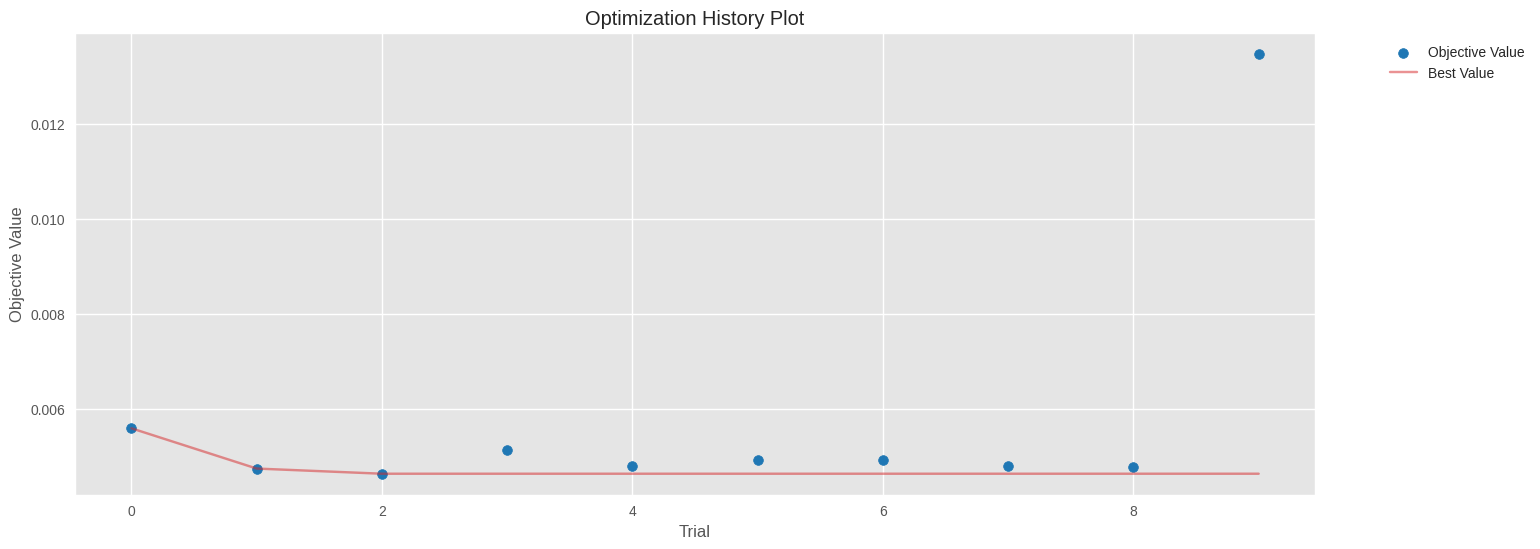

In [ ]:
plot_optimization_history(study);

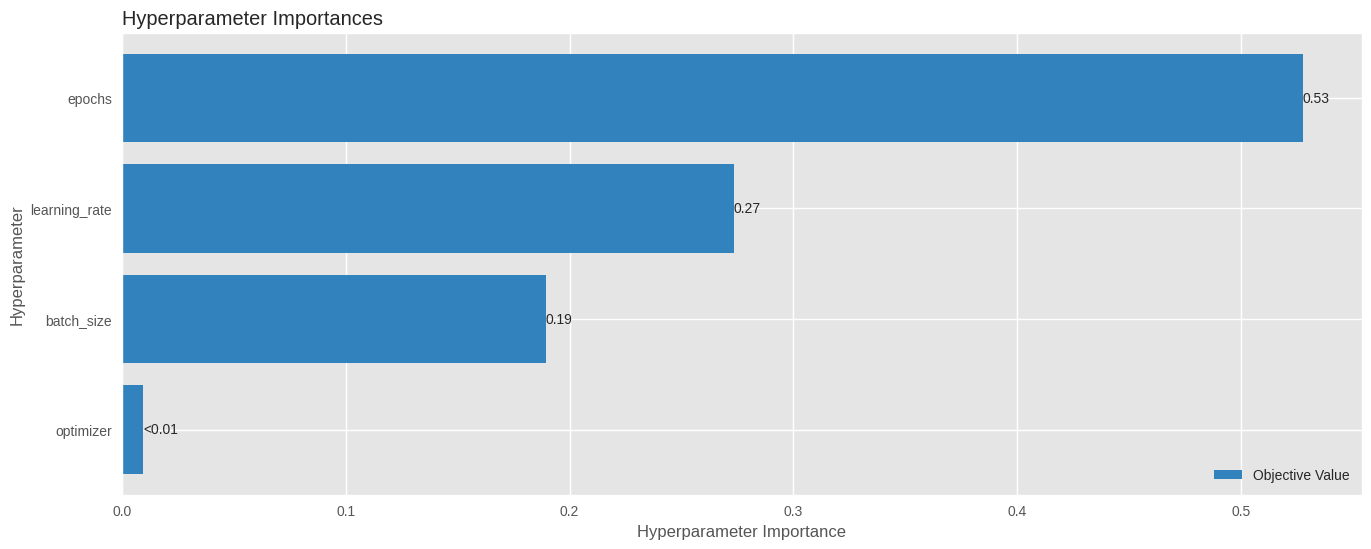

In [ ]:
plot_param_importances(study);

In [ ]:
optuna.visualization.plot_slice(study, params=['epochs', 'learning_rate'])

In [ ]:
# Print all keys in the best_params dictionary
for key in best_params.keys():
    print(best_params.keys())

dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])
dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])
dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])
dict_keys(['optimizer', 'learning_rate', 'epochs', 'batch_size'])


In [ ]:
# Define the LSTM model using the best hyperparameters
model = Sequential()

# Define default values or adjust as needed
lstm_units = 64
dropout_rate = 0.2

model = tf.keras.Sequential([
    LSTM(units=lstm_units, input_shape=(x_train.shape[1], x_train.shape[2])),
    Dropout(rate=dropout_rate),
    Dense(units=1)
])

# Compile the model using the best optimizer and learning rate from best_params
optimizer_val = list(best_params)[0]  # Retrieve the optimizer key from best_params

if optimizer_val == 'Adam':
    optimizer = optimizers.Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = optimizers.RMSprop(learning_rate=best_params['learning_rate'])

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


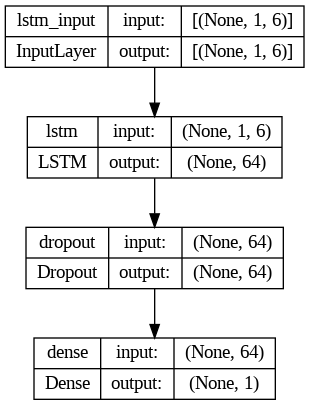

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
%%time
history = model.fit(x_train, y_train, epochs=best_params['epochs'], validation_data=(x_val, y_val), batch_size=best_params['batch_size'], verbose=0)

CPU times: user 1min 7s, sys: 4.16 s, total: 1min 11s
Wall time: 1min 23s


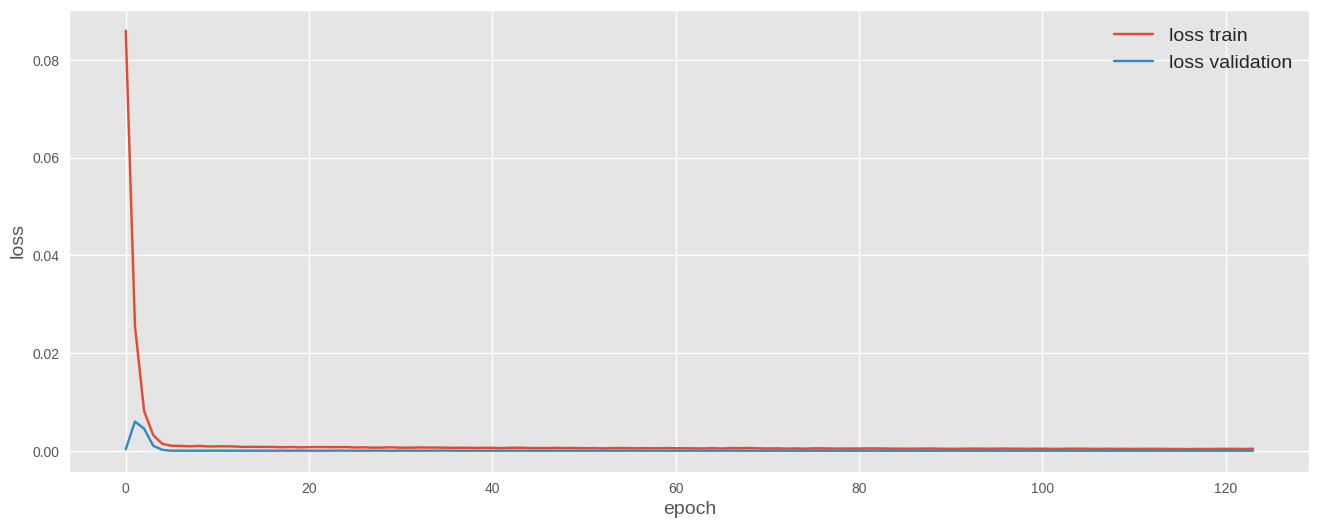

In [ ]:
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss validation')
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
model.evaluate(x_test, y_test, batch_size=best_params['batch_size'])

4/4 [==============================] - 0s 4ms/step - loss: 7.2663e-05 - accuracy: 0.0000e+00


[7.266338070621714e-05, 0.0]

In [ ]:
yhat_train = np.squeeze(model.predict(x_train))
yhat_test = np.squeeze(model.predict(x_test))

2/2 [==============================] - 0s 7ms/step


In [ ]:
yhat_train = scaler.inverse_transform(prep_data_transform(yhat_train, X_train.shape[1]))[:,0]
yhat_test = scaler.inverse_transform(prep_data_transform(yhat_test, X_test.shape[1]))[:,0]
print(yhat_train.shape, yhat_test.shape)

(2112,) (55,)


In [ ]:
print('Train Predicted: ', yhat_train[:5])
print('Train Actual: ', Y_train[:5])

print('Test Predicted: ', yhat_test[:5])
print('Test Actual: ', Y_test[:5])

Train Predicted:  [17.66009552 16.55070188 15.98805723 15.62157321 16.4027779 ]
Train Actual:  [18. 16. 16. 16. 17.]
Test Predicted:  [7.10923187 7.04889285 7.21016477 7.38963158 7.37234202]
Test Actual:  [7. 7. 7. 7. 7.]


In [ ]:
# calculate root mean squared error
trainScore = mean_squared_error(Y_train, yhat_train, squared=False)
print('Train Score: %.2f RMSE' % (trainScore))

testScore = mean_squared_error(Y_test, yhat_test, squared=False)
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.40 RMSE
Test Score: 0.39 RMSE


In [ ]:
date_train = df['Date'][LAG_DAYS:len(Y_train) + LAG_DAYS]
date_test = df['Date'][-len(Y_test):]

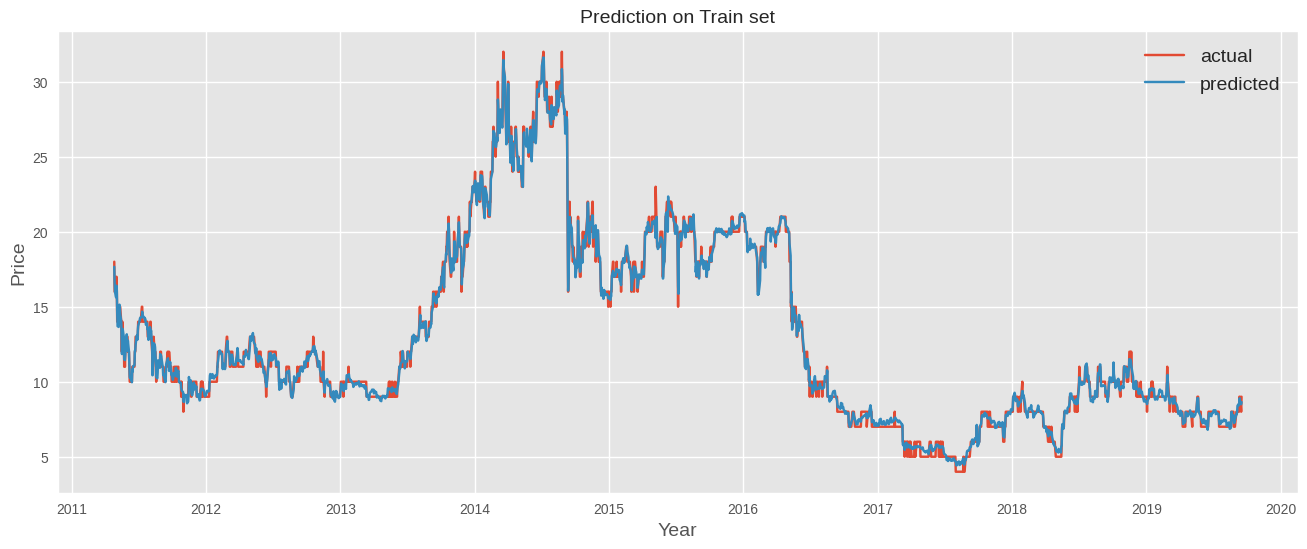

In [ ]:
plt.title('Prediction on Train set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_train, Y_train, label='actual')
plt.plot(date_train, yhat_train, label='predicted')
plt.legend(fontsize=14)
plt.show()

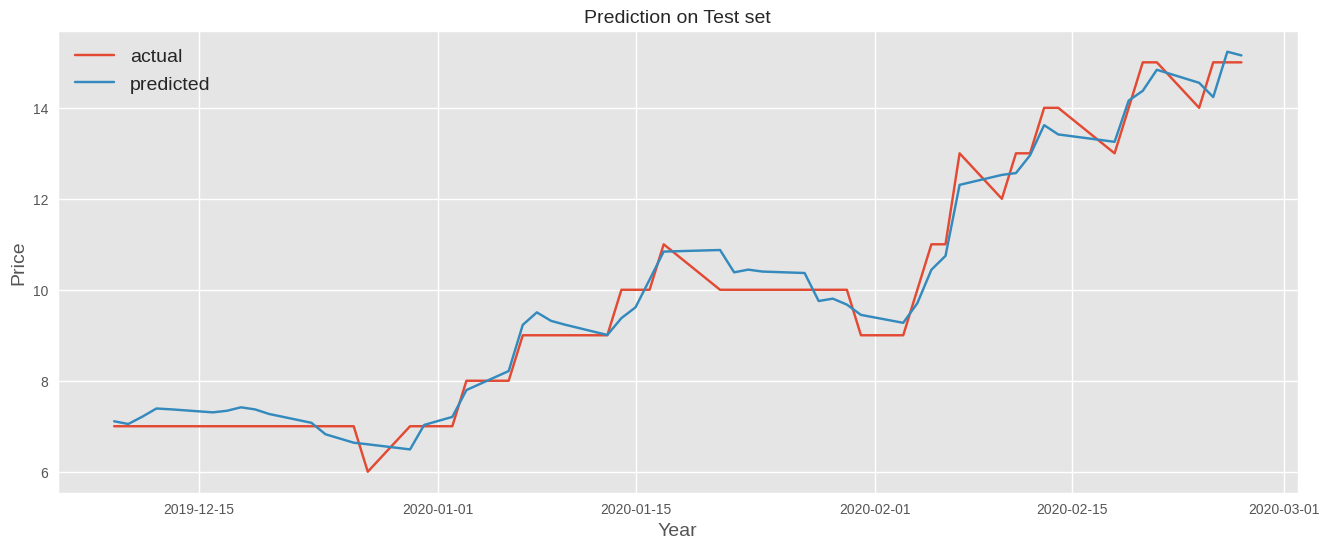

In [ ]:
plt.title('Prediction on Test set', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.plot(date_test, Y_test, label='actual')
plt.plot(date_test, yhat_test, label='predicted')
plt.legend(fontsize=14)
plt.show()

In [ ]:
# prompt: convert yhat_test into a list

yhat_test_list = yhat_test.tolist()
yhat_test_list

[7.109231865243562,
 7.048892850316116,
 7.210164769134283,
 7.389631579304278,
 7.372342020029009,
 7.305013372450516,
 7.339376494936437,
 7.4158650213390445,
 7.370160048355289,
 7.269354067866348,
 7.0756288431945595,
 6.823530373493887,
 6.6380300732522235,
 6.602730556398548,
 6.490385654716626,
 7.028544375344776,
 7.205155717540518,
 7.795206772706315,
 8.213204002639815,
 9.228647581570566,
 9.503478917085424,
 9.317221602064908,
 9.232431832622677,
 9.006427127501652,
 9.376985861749933,
 9.61376856478487,
 10.22375420532009,
 10.839373023220555,
 10.874431447324008,
 10.38319591748406,
 10.442767632105769,
 10.40052538460365,
 10.368388872978135,
 9.752742078444541,
 9.804951001499758,
 9.674028586865827,
 9.44756062161383,
 9.273264140099183,
 9.704931246686026,
 10.440697772675112,
 10.745478916799396,
 12.306260719835668,
 12.525379470416665,
 12.56555885264641,
 12.956242660222053,
 13.619232912172436,
 13.414991970522344,
 13.252457606134117,
 14.15904533981341,
 14.374

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_test' contains actual values and 'yhat_test' contains predicted values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_test, yhat_test)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, yhat_test)

# Calculate R-squared (R2) score
r2 = r2_score(Y_test, yhat_test)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((Y_test - yhat_test) / Y_test)) * 100

# Display the Mean Absolute Percentage Error (MAPE)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 0.14889137628512528
Root Mean Squared Error (RMSE): 0.38586445325415153
Mean Absolute Error (MAE): 0.3367332018962971
R-squared (R2) Score: 0.9798570477074015
Mean Absolute Percentage Error (MAPE): 3.53%


In [ ]:
# Assuming 'Y_train' contains actual values and 'yhat_train' contains predicted values

# Calculate Mean Absolute Percentage Error (MAPE)
mape_train = np.mean(np.abs((Y_train - yhat_train) / Y_train)) * 100

# Display the Mean Absolute Percentage Error (MAPE) for the training set
print(f'Mean Absolute Percentage Error (MAPE) on Training set: {mape_train:.2f}%')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'Y_train' contains the actual values and 'yhat_train' contains the predicted values for the training set

# Calculate Mean Squared Error (MSE) on the training set
mse_train = mean_squared_error(Y_train, yhat_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Error (MAE) on the training set
mae_train = mean_absolute_error(Y_train, yhat_train)

# Calculate R-squared (R2) score on the training set
r2_train = r2_score(Y_train, yhat_train)

# Display the accuracy metrics for the training set
print(f'Mean Squared Error (MSE) on Training set: {mse_train:.2f}')
print(f'Root Mean Squared Error (RMSE) on Training set: {rmse_train:.2f}')
print(f'Mean Absolute Error (MAE) on Training set: {mae_train:.2f}')
print(f'R-squared (R2) Score on Training set: {r2_train:.2f}')

Mean Absolute Percentage Error (MAPE) on Training set: 2.86%
Mean Squared Error (MSE) on Training set: 0.16
Root Mean Squared Error (RMSE) on Training set: 0.40
Mean Absolute Error (MAE) on Training set: 0.30
R-squared (R2) Score on Training set: 1.00


In [ ]:
import numpy as np

def calculate_forecast_accuracy(yhat_test, Y_test):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_test - Y_test) / Y_test
    return accuracy

# Compute forecast accuracy for the test set
forecast_accuracy = calculate_forecast_accuracy(yhat_test, Y_test)

# Calculate the mean accuracy across all data points
mean_accuracy = np.mean(forecast_accuracy)

print(f'Mean Forecast Accuracy on Test Set: {mean_accuracy:.2f}')

Mean Forecast Accuracy on Test Set: 0.96


In [ ]:
def calculate_forecast_accuracy(yhat_train, Y_train):
    # Calculate the forecast accuracy using the given formula
    accuracy = 1 - np.abs(yhat_train - Y_train) / Y_train
    return accuracy

# Compute forecast accuracy for the training set
forecast_accuracy_train = calculate_forecast_accuracy(yhat_train, Y_train)

# Calculate the mean accuracy across all data points
mean_accuracy_train = np.mean(forecast_accuracy_train)

print(f'Mean Forecast Accuracy on Training Set: {mean_accuracy_train:.2f}')

Mean Forecast Accuracy on Training Set: 0.97
